In [1]:
# Gerekli kütüphanelerin import edildiği alan.
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import warnings
import matplotlib.cm as cm
warnings.filterwarnings('ignore') # Warninglerin gizlenmesi için

learning_rates = [0.001, 0.01]
batch_sizes = [64, 128]
results = []
epoch = 50

data_dir = "/kaggle/input/animals10/raw-img/"
tf.keras.mixed_precision.set_global_policy('mixed_float16')
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.3),
  layers.RandomContrast(0.4),
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


2025-09-26 23:35:27.976333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758929728.242091      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758929728.318230      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1758929742.473679      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758929742.474437      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Proje Kurulumu ve Parametrelerin Belirlenmesi
Bu bölümde projemiz için gerekli olan temel kurulumları ve ayarları yapacağız.

1.1. Kütüphanelerin Yüklenmesi
İlk olarak, proje boyunca kullanacağımız kütüphaneleri import ediyoruz.

TensorFlow ve Keras: Derin öğrenme modelini oluşturmak, eğitmek ve değerlendirmek için ana yapımız.

Matplotlib ve Seaborn: Eğitim sonuçlarını, veri örneklerini ve performans özelliklerini görselleştirme aracıdır.

NumPy ve Pandas: Sayısal hesaplamalar ve sonuçları düzenli bir şekilde saklamak için.

Scikit-learn: Modelin performansını ölçmek için classification_report ve confusion_matrix gibi metrikleri kullanacağız.

1.2. Hiperparametrelerin ve Değişkenlerin Tanımlanması
Modelimizi eğitirken en iyi sonucu bulmak için deneyeceğimiz farklı hiperparametreleri burada belirliyoruz.

learning_rates ve batch_sizes: Farklı öğrenme oranları ve batch sizeler ile denemeler yaparak en iyi kombinasyonu bulmayı hedefliyoruz.

epoch: Tüm veri seti üzerinde atılacak tur sayısını ifade eder. (Epoch = 50, tüm veri setini 50 kere tekrar et.)

1.3. Veri ve Eğitim Ayarları
Veri yolu, veri artırma (data augmentation) ve eğitim sürecini optimize edecek bazı özel ayarları burada tanımlıyoruz.

data_dir: Veri setimizin bulunduğu dosya yolu.

Mixed Precision (mixed_float16): Bu ayar, modern ekran kartlarında (GPU) eğitimi önemli ölçüde hızlandırır. Hesaplamaların bir kısmını daha hızlı olan 16-bit'lik formatta yaparak bellek kullanımını azaltır ve performansı artırır. (Önemli bazı parametreler float32'den 32-bit olarak tutulmaya devam eder bu işlem GPU process sürecini hızlandırır)

Data Augmentation: Modelin veri setini ezberlemesini (overfitting) önlemek ve genelleme yeteneğini artırmak için mevcut resimlerden rastgele çevirme, döndürme, yakınlaştırma gibi işlemlerle yeni veri örnekleri üreten bir katman hazırlıyoruz.

Callbacks (EarlyStopping, ReduceLROnPlateau):

EarlyStopping: Modelin loss değeri belli bir patience içerisinde artmazsa model en iyi değeri alır ve döngüyü sonlandırır.

ReduceLROnPlateau: Modelin öğrenmesi yavaşladığında (overfit durumunda), öğrenme oranını otomatik olarak düşürerek modelin daha hassas adımlarla daha iyi bir sonuca ulaşmasına yardımcı olur.

In [2]:
for bs in batch_sizes:
    for lr in learning_rates:
        print(f"\n--- Batch Size={bs}, Learning Rate={lr} ---")

        train_val_dataset = tf.keras.utils.image_dataset_from_directory(
            data_dir, validation_split=0.2, subset="training", seed=1903,
            image_size=(120, 120), batch_size=bs
        )
        test_dataset = tf.keras.utils.image_dataset_from_directory(
            data_dir, validation_split=0.2, subset="validation", seed=1903,
            image_size=(120, 120), batch_size=bs
        )
        class_names = train_val_dataset.class_names
        
        total = tf.data.experimental.cardinality(train_val_dataset)
        val_batches = int(total.numpy() * 0.2)
        validation_dataset = train_val_dataset.take(val_batches)
        train_dataset = train_val_dataset.skip(val_batches)

        train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
        validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
        test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

        # DÜZELTME: Model, hatalı Sequential yapısı yerine doğru olan Fonksiyonel API ile oluşturuldu.
        # Girdi boyutu da veriyle uyumlu olacak şekilde 120x120 yapıldı.
        inputs = layers.Input(shape=(120, 120, 3))
        x = data_augmentation(inputs)
        x = layers.Rescaling(1./255)(x)
        x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(len(class_names), activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])

        history = model.fit(
            train_dataset, validation_data=validation_dataset, epochs=epoch,
            callbacks=[early_stopping, reduce_lr], verbose=1
        )

        print(f"--- DENEME TAMAMLANDI: Batch Size={bs}, Learning Rate={lr} ---")
        loss, accuracy = model.evaluate(test_dataset)
        print(f"Test Seti Sonucu -> Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        results.append({'batch_size': bs, 'learning_rate': lr, 'test_loss': loss, 'test_accuracy': accuracy})



--- Batch Size=64, Learning Rate=0.001 ---
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Epoch 1/50


I0000 00:00:1758929780.865649     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 123ms/step - accuracy: 0.1998 - loss: 2.6870 - val_accuracy: 0.1940 - val_loss: 2.7952 - learning_rate: 0.0010
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - accuracy: 0.3554 - loss: 2.0175 - val_accuracy: 0.1937 - val_loss: 4.0724 - learning_rate: 0.0010
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.4221 - loss: 1.8052 - val_accuracy: 0.4075 - val_loss: 1.7728 - learning_rate: 0.0010
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.4672 - loss: 1.6525 - val_accuracy: 0.3950 - val_loss: 1.8259 - learning_rate: 0.0010
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.4911 - loss: 1.5608 - val_accuracy: 0.4048 - val_loss: 1.7859 - learning_rate: 0.0010
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.5157 - loss: 1.5026 - val_accuracy: 0.4481 - val_loss: 1.6387 - learning_rate: 0.0010
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.5319 - loss:

Hiperparametre Ayarı ve Model Eğitimi Döngüsü
Bu bölümde, projenin en kritik adımlarından birini gerçekleştiriyoruz: Farklı hiperparametre kombinasyonlarını sırasıyla deneyerek en iyi performansı gösteren modeli bulmak. Bu sürece hiperparametre arama (hyperparameter tuning) denir.

2.1. Döngü Yapısı
Önceden tanımladığımız batch_sizes ve learning_rates listelerindeki her bir olası kombinasyonu denemek için iç içe iki for döngüsü oluşturduk. Her döngü adımında:

Veri setleri mevcut batch_size'a göre yeniden yüklenir.

Model mimarisi sıfırdan oluşturulur.

Model, mevcut learning_rate ile derlenir ve eğitilir.

Eğitim sonrası aralarından en mantıklı performansın bulunması amacıyla 'batch_size': bs, 'learning_rate': lr, 'test_loss': loss, 'test_accuracy': accuracy olarak kaydedilir.

2.2. Veri Setlerinin Hazırlanması
Her döngünün başında, verileri image_dataset_from_directory fonksiyonu ile Kaggle klasörümüz üzerinden okuyoruz.

Veri Bölümleme: Veri setini %80 eğitim ve %20 test olarak ayırıyoruz. Daha sonra, eğitim için ayırdığımız %80'lik kısmın da %20'sini doğrulama (validation) seti olarak ayırıyoruz. Bu, modelin eğitim sırasında performansını izlemek ve ezberlemeyi (overfitting) önlemek için kritik bir adımdır.

Performans Optimizasyonu (prefetch): prefetch(buffer_size=AUTOTUNE) komutu, model eğitilirken bir sonraki veri yığınının arka planda hazırlanmasını sağlar.Bu yapı, GPU'nun arka planda dolmasını azaltarak CPU'nun veriyi sıraya koymasını sağlar. İşlem hızında artış sağlar

2.3. Modelin Oluşturulması ve Derlenmesi
Her deneme için temiz bir başlangıç yapmak amacıyla modeli döngünün içinde yeniden oluşturuyoruz.

Model Mimarisi: Modelimiz, Keras'ın Fonksiyonel API'si kullanılarak oluşturulmuştur. Bu yapı, katmanların birbirine nasıl bağlandığı konusunda daha fazla esneklik sağlar. Mimari, özellik haritalarını çıkarmak için SeparableConv2D katmanlarından ve eğitimi stabilize etmek için BatchNormalization katmanlarından oluşur. Son olarak GlobalAveragePooling2D ve Dense katmanları ile sınıflandırma yapılır.
##Overfitting ile mücadelede GlobalAveragePooling2D ve SeperableConv2D katmanlarını önemli rol oynarlar. Normalde sırasıyla karşılık geldikleri Flatten ve Conv2D değişkenleri nöronlar içinde gereksiz parametreler bulundurarak overfittinge yol açarken bu iki değişken çok daha verimli ve çok daha stabil çalışmakta onların yaptığı işi daha yüzeysel yaparak nöronlara binen ağırlıkları dengeleler. BatchNormalization ise katmanlar arasında sürekli değişen bilginin anlaşılabilir kalmasında rol oynar.

Derleme (compile): Modeli, popüler bir optimize edici olan Adam ile derliyoruz. Döngüden gelen learning_rate (öğrenme oranı) bu adımda kullanılır. Kayıp fonksiyonu olarak çok sınıflı sınıflandırma için standart olan SparseCategoricalCrossentropy seçilmiştir.

2.4. Eğitim ve Sonuçların Kaydedilmesi
Eğitim (fit): Model, train_dataset üzerinde eğitilirken, her epoch sonunda performansını validation_dataset üzerinde kontrol eder. Eğitim, daha önce tanımladığımız early_stopping ve reduce_lr callback'leri ile kontrol altında tutulur.

Değerlendirme (evaluate): Eğitim tamamlandıktan sonra, modelin daha önce hiç görmediği test_dataset üzerindeki performansı ölçülür.

Sonuçların Kaydı: Her denemenin sonunda kullanılan hiperparametreler (bs, lr) ve elde edilen test performansı (loss, accuracy) results listesine bir sözlük olarak eklenir. Döngü bittiğinde bu liste, en iyi modeli seçmek için analiz edilecektir.

In [3]:
results_df = pd.DataFrame(results)
print("--- Tüm Deneme Sonuçları ---")
print(results_df)
print("-" * 30)

best_result_index = results_df['test_accuracy'].idxmax()
best_result_series = results_df.loc[best_result_index]
best_batch_size = int(best_result_series['batch_size'])
best_learning_rate = float(best_result_series['learning_rate'])

print("\n--- En İyi Sonuç ---")
print(best_result_series)
print("-" * 30)
print(f"\nEn iyi Batch Size: {best_batch_size}")
print(f"En iyi Learning Rate: {best_learning_rate}")
print(f"Elde edilen en yüksek Test Accuracy: {best_result_series['test_accuracy']:.4f}")

--- Tüm Deneme Sonuçları ---
   batch_size  learning_rate  test_loss  test_accuracy
0          64          0.001   0.984670       0.680420
1          64          0.010   0.932943       0.704489
2         128          0.001   1.234703       0.598854
3         128          0.010   0.952434       0.705826
------------------------------

--- En İyi Sonuç ---
batch_size       128.000000
learning_rate      0.010000
test_loss          0.952434
test_accuracy      0.705826
Name: 3, dtype: float64
------------------------------

En iyi Batch Size: 128
En iyi Learning Rate: 0.01
Elde edilen en yüksek Test Accuracy: 0.7058


Sonuçların Analizi ve En İyi Modelin Seçimi
Hiperparametre arama döngüsü tamamlandıktan sonra, hangi denemenin en iyi sonucu verdiğini bulmamız gerekiyor. Bu bölümde, tüm denemelerden elde edilen sonuçları analiz ederek en başarılı modelin parametrelerini seçmek amacıyla pandas kütüphanesi kullanacağız.

3.1. Sonuçların DataFrame'e Dönüştürülmesi
Önceki adımda results listesinde biriktirdiğimiz tüm deneme sonuçlarını, daha kolay okunabilir ve analiz edilebilir bir yapı olan Pandas DataFrame'ine dönüştürüyoruz. Bu tablo, her bir batch_size ve learning_rate kombinasyonunun test seti üzerindeki kayıp (loss) ve doğruluk (accuracy) değerlerini net bir şekilde gösterir.

3.2. En Yüksek Doğruluğa Sahip Modelin Bulunması
DataFrame içerisinden en iyi modeli bulmak için test_accuracy sütununu referans alıyoruz.

.idxmax() Fonksiyonu: Bu fonksiyon, test_accuracy sütunundaki en yüksek değere sahip olan satırın indeksini (yani indexini) bize verir.

.loc[] ile Seçim: Elde ettiğimiz bu indeks numarasını kullanarak, en iyi denemeye ait tüm bilgileri (batch size, learning rate, loss, accuracy) içeren satırı seçiyoruz.

3.3. En İyi Parametrelerin Ayıklanması ve Gösterilmesi
En iyi sonucu veren satırı bulduktan sonra, o denemede kullanılan batch_size ve learning_rate değerlerini ayrı değişkenlere atıyoruz. Bu değerler, projenin sonraki adımında final modelimizi eğitmek için kullanılacaktır.

Son olarak, en iyi denemenin tüm detaylarını ve en yüksek test doğruluğu değerini ekrana yazdırarak hiperparametre arama sürecinin sonucunu net bir şekilde özetliyoruz.

In [4]:
# En iyi parametrelerle nihai veri setlerini oluşturma
best_train_val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training", seed=1903,
    image_size=(120, 120), batch_size=best_batch_size
)
best_test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=1903,
    image_size=(120, 120), batch_size=best_batch_size
)
class_names = best_train_val_dataset.class_names

best_total = tf.data.experimental.cardinality(best_train_val_dataset)
val_batches = int(best_total.numpy() * 0.2)
best_validation_dataset = best_train_val_dataset.take(val_batches)
best_train_dataset = best_train_val_dataset.skip(val_batches)

best_train_dataset = best_train_dataset.prefetch(buffer_size=AUTOTUNE)
best_validation_dataset = best_validation_dataset.prefetch(buffer_size=AUTOTUNE)
best_test_dataset = best_test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


Final Modeli için Veri Setlerinin Hazırlanması
Hiperparametre arama sürecinde en iyi batch_size (batch) ve learning rate değerini bulduk. Şimdi, bu en iyi hiperparametreyi kullanarak nihai (final) modelimizi eğitmek üzere veri setlerimizi son bir kez hazırlayacağız.

4.1. Best HyperParametrelerle Veri Yükleme
image_dataset_from_directory fonksiyonunu tekrar çağırıyoruz, ancak bu sefer batch_size hiperparametresi olarak daha önce belirlediğimiz best_batch_size değişkenini kullanıyoruz. Bu, modelimizin bulduğumuz en verimli koşullar altında eğitilmesini sağlar. Veri setlerini yine aynı seed değeri ile bölerek tutarlılığı koruyoruz.

4.2. Veri Setlerinin Bölümlenmesi ve Optimize Edilmesi
Tıpkı eğitim döngüsünde olduğu gibi, ana eğitim setimizi tekrar bir eğitim (best_train_dataset) ve bir doğrulama (best_validation_dataset) seti olarak ikiye ayırıyoruz.

Son olarak, oluşturduğumuz üç veri setine de (train, validation, test) prefetch optimizasyonunu uyguluyoruz. Bu, nihai modelin eğitimi ve değerlendirilmesi sırasında veri akışının akıcı ve hızlı olmasını garanti eder. Artık en iyi hiperparametrelerle hazırlanmış veri setlerimiz, nihai modelimizi eğitmeye hazır.

(Yukarda yapılmış işlemlerin accurate hyperparameter'lere göre yapılmışı)

In [5]:
# DÜZELTME: Nihai model de doğru olan Fonksiyonel API ile ve doğru boyutla (120x120) oluşturuldu.
final_inputs = layers.Input(shape=(120, 120, 3))
x = data_augmentation(final_inputs)
x = layers.Rescaling(1./255)(x)
x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
# DÜZELTME: Grad-CAM için son evrişimli katmana özel bir isim veriyoruz.
x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu', name="last_conv_layer")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
final_outputs = layers.Dense(len(class_names), activation='softmax')(x)
final_model = tf.keras.Model(inputs=final_inputs, outputs=final_outputs)

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("\n--- Nihai Model Mimarisi ---")
final_model.summary()


--- Nihai Model Mimarisi ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_24             │ (None, 120, 120, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 120, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_25             │ (None, 120, 120, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 120, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_26             │ (None, 60, 60, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_27             │ (None, 60, 60, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_28             │ (None, 30, 30, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer                 │ (None, 30, 30, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 128)    │             

 Total params: 55,301 (216.02 KB)

 Trainable params: 54,149 (211.52 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [6]:
print("\n--- Nihai Model Eğitiliyor ---")
best_history = final_model.fit(
    best_train_dataset,
    validation_data=best_validation_dataset,
    epochs=epoch, # İsterseniz daha uzun bir epoch belirleyebilirsiniz
    callbacks=[early_stopping, reduce_lr]
)


--- Nihai Model Eğitiliyor ---
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.1981 - loss: 2.6956 - val_accuracy: 0.1931 - val_loss: 2.3940 - learning_rate: 0.0100
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.3403 - loss: 2.0037 - val_accuracy: 0.1951 - val_loss: 3.0060 - learning_rate: 0.0100
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.4062 - loss: 1.7685 - val_accuracy: 0.1816 - val_loss: 3.0979 - learning_rate: 0.0100
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.4480 - loss: 1.6454 - val_accuracy: 0.3000 - val_loss: 2.1691 - learning_rate: 0.0100
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - accuracy: 0.4855 - loss: 1.5667 - val_accuracy: 0.3970 - val_loss: 1.9418 - learning_rate: 0.0100
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 32s 224ms/step - accuracy: 0.5209 - loss: 1.4670 - val_accuracy: 0.4771 - val_loss: 1.7431 - learning_rate: 0.0100
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━

Nihai Modelin Oluşturulması ve Derlenmesi
Artık en iyi hiperparametreleri bildiğimize ve veri setlerimizi bu parametrelere göre hazırladığımıza göre, projenin son ürünü olacak nihai modelimizi oluşturabiliriz.

5.1. Model Mimarisi
Model, hiperparametre arama döngüsünde kullandığımızla tamamen aynı mimariye sahiptir. Bu tutarlılık, bulduğumuz en iyi parametrelerin bu model için de geçerli olmasını sağlar.

Fonksiyonel API: Modelimiz yine Keras'ın esnek Fonksiyonel API'si ile oluşturulmuştur.

Önemli Not - Bu modelde kritik bir ekleme yapılmıştır. Son SeparableConv2D katmanına özel olarak name="last_conv_layer" ismi verilmiştir. Bu isimlendirme, modelin bir tahminde bulunurken resmin hangi bölgelerine odaklandığını görselleştirmemizi sağlayan Grad-CAM tekniğini daha sonra kolayca uygulayabilmek için yapılmış bilinçli-destekli bir adımdır.

5.2. Modelin Derlenmesi
Model, eğitime hazır hale getirilmek üzere derlenir.

Optimize Edici: optimizer olarak Adam seçilmiştir, ancak bu sefer learning_rate (öğrenme oranı) olarak, önceki adımlarda bulduğumuz en iyi değeri (best_learning_rate) kullanıyoruz. Bu, hiperparametre arama sürecinin en önemli çıktısıdır.

Kayıp ve Metrikler: Kayıp fonksiyonu ve performans metriği, döngüdekiyle aynı tutularak tutarlılık sağlanır.

5.3. Model Özetinin Görüntülenmesi
final_model.summary() komutu ile oluşturduğumuz modelin mimarisini metin formatında ekrana yazdırıyoruz. Bu özet, katmanları, her katmanın çıktı boyutunu ve modeldeki toplam parametre sayısını göstererek her şeyin doğru bir şekilde kurulduğunu teyit etmemize olanak tanır

(İlk döngümüzde yaptığımız adımların best hyperparametrelere göre düzenlenmiş hali)

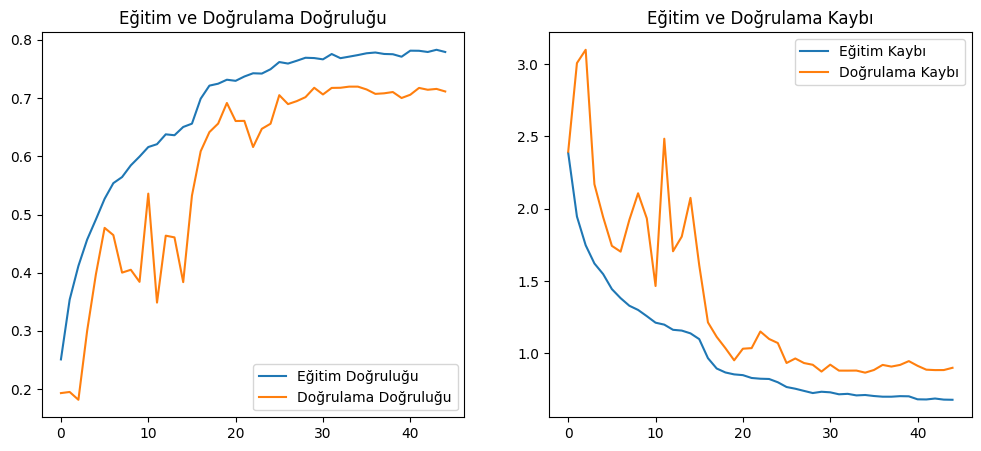

In [7]:
acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

Final Modelinin Eğitim Sürecinin Değerlendirilmesi
Modelimizi en iyi hiperparametrelerle eğittik. Bu bölümde, eğitim sürecinin nasıl ilerlediğini görmek için doğruluk (accuracy) ve kayıp (loss) metriklerini epoch'lara (döngülere) göre görselleştireceğiz. Bu grafikler, modelimizin "sağlıklı" bir şekilde öğrenip öğrenmediğini ve ezber yapıp yapmadığını (overfitting) anlamamızı sağlar.

6.1. Eğitim ve Doğrulama Grafikleri
model.fit fonksiyonundan dönen history objesi, her epoch'taki eğitim ve doğrulama bilgilerini içerir. Bu verileri kullanarak iki ana grafik çizdiriyoruz:

Eğitim ve Doğrulama Doğruluğu: Modelin her epoch'ta eğitim ve doğrulama setlerindeki doğruluk oranının değişimini gösterir.

Eğitim ve Doğrulama Kaybı: Modelin tahminlerinin gerçek değerlerden ne kadar saptığını gösteren kayıp değerinin değişimini gösterir.

6.2. Grafiklerin Yorumlanması
Grafiklere baktığımızda birkaç önemli sonuç çıkarabiliriz:

Model öğreniyor. Eğitim doğruluğu (mavi çizgi) sürekli artarken, eğitim kaybı (mavi çizgi) sürekli azalıyor. Bu, modelin eğitim verilerindeki desenleri başarıyla öğrendiğini gösteriyor.

Ama bazı durumlarda Overfitting riski ile karşı karşıyayız. Mavi çubuğun artış sağladığı fakat turuncu çizgilerin azalıp-yerinde saydığı yerlerde overfitting riski ile karşı karşıyayız

Sonuç: Modelimiz görevini yerine getirip öğrenme işlemini gerçekleştirse de, genelleme yeteneği bir noktadan sonra tıkanıyor. Kullandığımız data_augmentation, Dropout ve L2 regularizer gibi teknikler bu durumu engellemeye yönelikti ve muhtemelen daha da kötü olmasını engellediler, ancak yine de overfitting'i tamamen ortadan kaldıramadılar zaman zaman modelimiz overfitting oldu. Bu durumda, modelin karmaşıklığını azaltmak veya daha fazla veri artırma tekniği denemek ya da transfer learning ile daha iyi veri setleriyle eğitilmiş modeller kullanımı ile overfitting'in önüne geçilmesi planlanabilir.

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

        cane       0.19      0.13      0.15       939
     cavallo       0.10      0.08      0.09       511
    elefante       0.07      0.12      0.08       285
    farfalla       0.08      0.08      0.08       419
     gallina       0.11      0.14      0.12       618
       gatto       0.04      0.03      0.03       327
       mucca       0.07      0.05      0.06       408
      pecora       0.08      0.09      0.09       374
       ragno       0.18      0.17      0.18       971
  scoiattolo       0.06      0.07      0.06       383

    accuracy                           0.11      5235
   macro avg       0.10      0.10      0.09      5235
weighted avg       0.12      0.11      0.11      5235



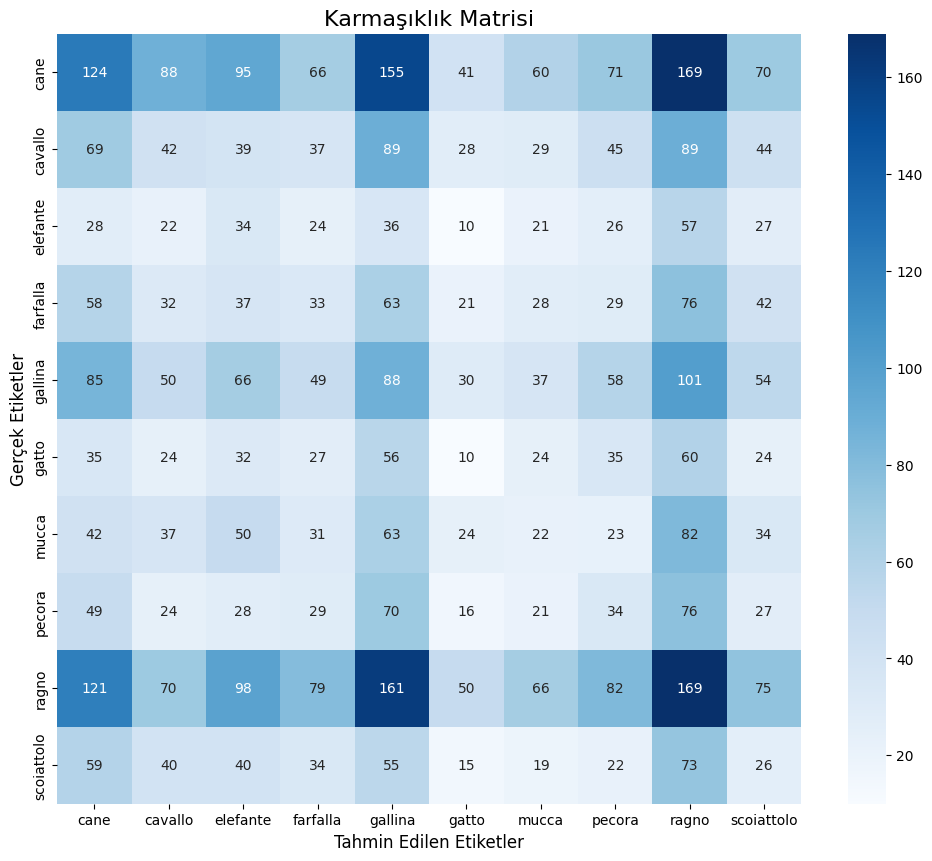


Doğru ve yanlış tahmin örnekleri gösteriliyor...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


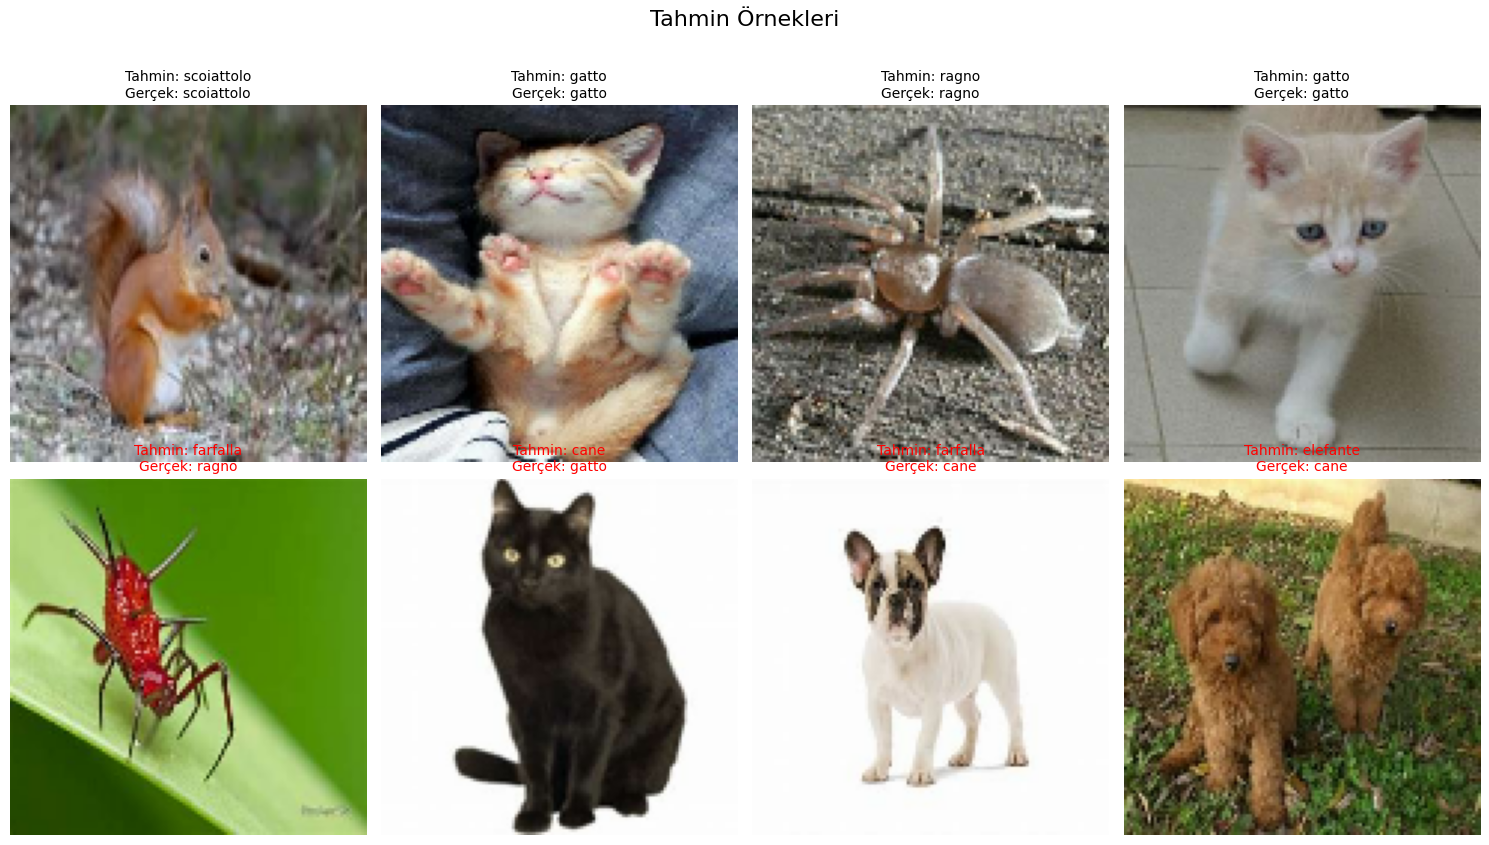

In [10]:
y_true = []
y_pred_probs = final_model.predict(best_test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
for _, labels in best_test_dataset:
    y_true.extend(labels.numpy())

print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi', fontsize=16)
plt.xlabel('Tahmin Edilen Etiketler', fontsize=12)
plt.ylabel('Gerçek Etiketler', fontsize=12)
plt.show()

# Doğru ve Yanlış Tahmin Örnekleri
print("\nDoğru ve yanlış tahmin örnekleri gösteriliyor...")
for image_batch, label_batch in best_test_dataset.take(1):
    images_np = image_batch.numpy()
    labels_np = label_batch.numpy()
    pred_probs_batch = final_model.predict(images_np)
    pred_classes_batch = np.argmax(pred_probs_batch, axis=1)
    correct_indices = np.where(pred_classes_batch == labels_np)[0]
    incorrect_indices = np.where(pred_classes_batch != labels_np)[0]

    plt.figure(figsize=(15, 9))
    plt.suptitle("Tahmin Örnekleri", fontsize=16)
    for i, correct_idx in enumerate(correct_indices[:4]):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images_np[correct_idx].astype("uint8"))
        plt.title(f"Tahmin: {class_names[pred_classes_batch[correct_idx]]}\nGerçek: {class_names[labels_np[correct_idx]]}", fontsize=10)
        plt.axis('off')
    for i, incorrect_idx in enumerate(incorrect_indices[:4]):
        plt.subplot(2, 4, i + 5)
        plt.imshow(images_np[incorrect_idx].astype("uint8"))
        plt.title(f"Tahmin: {class_names[pred_classes_batch[incorrect_idx]]}\nGerçek: {class_names[labels_np[incorrect_idx]]}", fontsize=10, color='red')
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Modelin Kapsamlı Performans Analizi
Modelimizi eğittik ve eğitim sürecini değerlendirdik. Artık son ve en önemli adıma geldik: Modelin daha önce hiç görmediği test verileri üzerindeki nihai performansını hem sayısal metriklerle hem de görsel örneklerle detaylı bir şekilde analiz etmek.

7.1. Sayısal Değerlendirme: Raporlar ve Matrisler
Modelin ne kadar başarılı olduğunu anlamak için standart sınıflandırma metriklerini kullanıyoruz.

Sınıflandırma Raporu (Classification Report): Bu rapor, her bir sınıf için modelin performansını ayrı ayrı özetler.

Precision (Kesinlik): Modelin bir sınıf için yaptığı tahminlerin ne kadarının doğru olduğunu belirtir. (Örn: "kedi" diye tahmin ettiklerinin % kaçı gerçekten kedi?)

Recall (Duyarlılık): Gerçekte o sınıfa ait olan örneklerin ne kadarını modelin doğru tespit edebildiğini belirtir. (Örn: Gerçek kedilerin % kaçını "kedi" olarak bulabildi?)

F1-Skoru: Precision ve Recall metriklerinin harmonik ortalamasıdır ve modelin genel başarısı hakkında dengeli bir fikir verir.

Karmaşıklık Matrisi (Confusion Matrix): Bu matris, modelin hangi sınıfları birbiriyle karıştırdığını görsel olarak anlamak için en iyi araçtır. Matrisin köşegenindeki (sol üstten sağ alta) sayılar doğru tahminleri, diğer hücreler ise yanlış tahminleri gösterir. Örneğin, "at" satırı ile "geyik" sütununun kesişimindeki sayı, modelin kaç tane at resmini yanlışlıkla geyik olarak sınıflandırdığını gösterir.

7.2. Niteliksel Değerlendirme: Görsel Örnekler
Sayısal metrikler genel performansı gösterse de, modelin neden ve nerede hata yaptığını anlamak için gerçek resim örneklerini görmek çok değerlidir.

Doğru ve Yanlış Tahmin Örnekleri: Bu bölümde, test setinden rastgele seçilen bazı görselleri ve modelin bunlar için yaptığı tahminleri inceliyoruz.

Üst Sıra: Modelin doğru tahmin ettiği örnekler.

Alt Sıra: Modelin yanlış tahmin ettiği örnekler (kırmızı başlıkla belirtilmiştir).

Bu görsel analiz, modelin güçlü ve zayıf yönleri hakkında bize sezgisel bir anlayış kazandırır. Belki de model, belirli hayvan türlerini, farklı açılardan çekilmiş fotoğrafları veya karmaşık arka planları ayırt etmekte zorlanıyordur. Bu tür gözlemler, modeli gelecekte iyileştirmek için bize değerli ipuçları sunar.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

--- Grad-CAM Isı Haritası Analizi ---


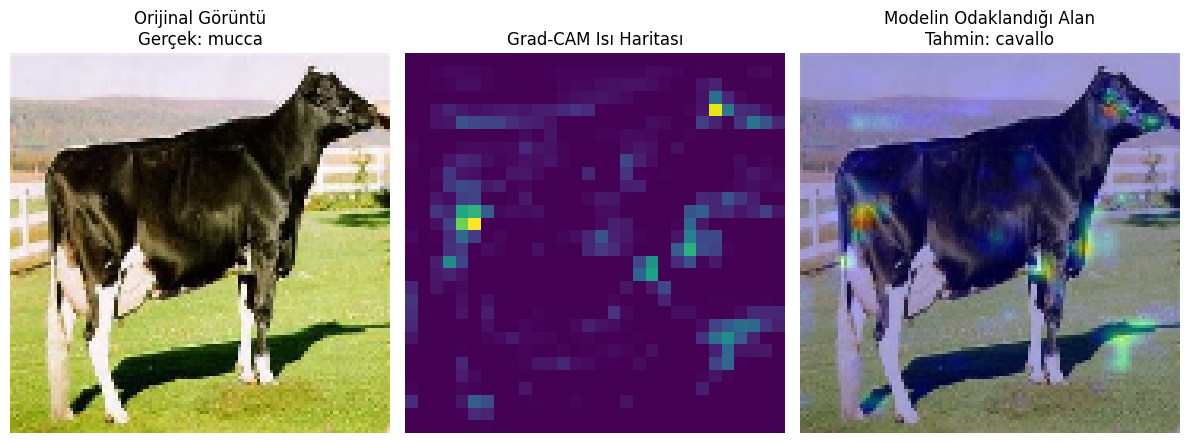

In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-7)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, alpha=0.6):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet") 
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img
# Test setinden bir örnek al
image_batch, label_batch = next(iter(best_test_dataset))
sample_image = image_batch[0].numpy().astype('uint8')
sample_label = label_batch[0].numpy()

# DÜZELTME: Görüntü boyutu (120x120) modelle zaten uyumlu olduğu için yeniden boyutlandırma kaldırıldı.
img_array = np.expand_dims(sample_image, axis=0)

# DÜZELTME: Modelde verdiğimiz özel katman adını kullanıyoruz.
last_conv_layer_name = "last_conv_layer"

# Önce tahmin yap, sonra ısı haritasını oluştur
preds = final_model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = make_gradcam_heatmap(img_array, final_model, last_conv_layer_name)
superimposed_img = save_and_display_gradcam(sample_image, heatmap)

# Sonuçları görselleştir
print("\n--- Grad-CAM Isı Haritası Analizi ---")
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title(f"Orijinal Görüntü\nGerçek: {class_names[sample_label]}")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Isı Haritası")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title(f"Modelin Odaklandığı Alan\nTahmin: {class_names[predicted_class]}")
plt.axis('off')
plt.tight_layout()
plt.show()


Modelin Karar Mekanizmasını Anlama: Grad-CAM
Modelimizin oldukça başarılı tahminler yaptığını gördük. Peki, model bir resme bakıp "bu bir at" derken, resmin tam olarak neresine odaklanıyor? Gözlerine mi, yelesine mi, yoksa tamamen alakasız bir arka plan detayına mı? Bu soruların cevabını anlamak, modelimizin doğru özellikleri öğrendiğinden emin olmamızı sağlar ve ona olan güvenimizi artırır.

8.1. Grad-CAM Nedir?
Grad-CAM (Gradient-weighted Class Activation Mapping), bir derin öğrenme modelinin bir karar verirken resmin hangi bölgelerini "önemli" bulduğunu gösteren bir görselleştirme tekniğidir. Kısacası, modelin "nereye baktığını" gösteren bir ısı haritası (heatmap) oluşturur. Isı haritasındaki sıcak renkler (kırmızı, sarı), modelin kararını en çok etkileyen bölgeleri gösterir.

8.2. Uygulama ve Sonuçlar
Kodumuz, bu tekniği uygulamak için birkaç adım izler:

Test setinden rastgele bir örnek resim seçilir.

make_gradcam_heatmap fonksiyonu, modelin son evrişim katmanındaki gradyanları (türevleri) kullanarak ham ısı haritasını hesaplar. Modelimizi oluştururken son katmana verdiğimiz özel last_conv_layer ismi, bu adımda doğru katmanı kolayca hedef almamızı sağlar.

save_and_display_gradcam fonksiyonu, bu ham haritayı renklendirir ve orijinal resmin üzerine yarı şeffaf bir şekilde bindirir.

Sonuç olarak üç görsel elde ederiz:

Orijinal Görüntü: Modelimize girdi olarak verdiğimiz resim.

Grad-CAM Isı Haritası: Modelin önemli bulduğu bölgeleri gösteren ham harita.

Modelin Odaklandığı Alan: Isı haritasının orijinal resim üzerine bindirilmiş, en sezgisel ve anlaşılır hali.

Yorum: İdeal bir durumda, ısı haritasının en sıcak bölgelerinin, tahmin edilen nesnenin (örneğin atın gövdesi, başı gibi) üzerinde yoğunlaştığını görmeyi bekleriz. Eğer model, nesnenin kendisi yerine sürekli olarak arka plan gibi alakasız yerlere odaklanıyorsa, bu durum modelin yanlış desenleri öğrenmiş olabileceğine dair bir ipucu olabilir. Bu analiz, modelimizin sadece doğru tahminler yapmakla kalmayıp, bunu "doğru sebeplerle" yaptığını teyit etmemiz için güçlü bir araçtır.